### Library Imports

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import vaex
import shapefile as sh
from h3 import h3
import json
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon, LinearRing, shape
from shapely.ops import unary_union
import folium
from folium.plugins import HeatMap
import shapely
import math

Quelle von den Daten hinzufügen

## Testing of general method with simple coordinates

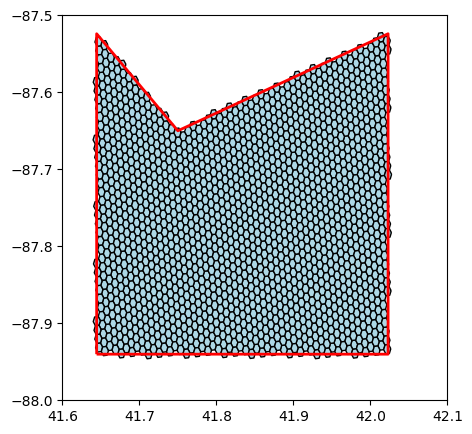

In [2]:
# Step 1: Define the boundary coordinates of Chicago (in this case just the shape of a quadrant)
chicago_boundary = [
    [41.64454, -87.94013],
    [41.64454, -87.52399],
    [41.7500, -87.65],
    [42.02303, -87.52399],
    [42.02303, -87.94013]
]

# Step 2: Define resolution level
resolution = 8

# Step 3: Generate H3 hexagons covering the city
hexagons = h3.polyfill_polygon(chicago_boundary, resolution)

# # Step 4: Remove hexagons outside the city
chicago_polygon = Polygon(chicago_boundary)
# hexagons_within_city = [
#     hexagon for hexagon in hexagons
#     if chicago_polygon.contains(Point(h3.h3_to_geo(hexagon)))
# ]


# Convert hexagons to geopandas GeoDataFrame
hexagon_geometries = [
    Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True))
    for hexagon in hexagons
]
hexagon_gdf = gpd.GeoDataFrame(geometry=hexagon_geometries)

#Transform Y to X Coordinates and the other way arround to match structure from the chicago boundary
hexagon_gdf = hexagon_gdf.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

# Create a plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the hexagons
hexagon_gdf.plot(ax=ax, facecolor='lightblue', edgecolor='black')

# Plot the city boundary
chicago_gdf = gpd.GeoDataFrame(geometry=[chicago_polygon])
chicago_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Set the axis limits
ax.set_ylim(-88, -87.5)
ax.set_xlim(41.6, 42.1)

# Display the plot
plt.show()

In [ ]:
#Possibility to explore the data within an add-on from folium to the geopandas dataframe
#hexagon_gdf.explore()

Import of chicago city boundary data from official website: 

In [3]:
city_bounding_box = gpd.read_file('data/trips/Boundaries - City.geojson')
city_bounding_box_json_string = city_bounding_box.to_json()
city_bounding_box_json = json.loads(city_bounding_box_json_string)
city_bounding_box_poly = city_bounding_box_json["features"][0]

<Axes: >

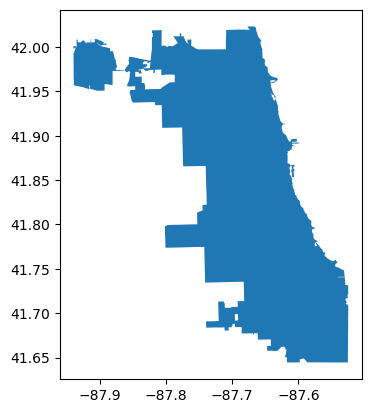

In [58]:
city_bounding_box.plot()

In [4]:
city_boundary = city_bounding_box_poly["geometry"]["coordinates"][1][0]


11326

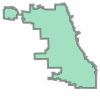

In [5]:
chicago_polygon= Polygon(city_boundary)
chicago_polygon

In [69]:
city_hole = city_bounding_box_poly["geometry"]["coordinates"][0][0]
len(city_hole)

32

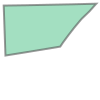

In [18]:
chicago_polygon_hole= Polygon(city_hole)
chicago_polygon_hole

(41.6, 42.1)

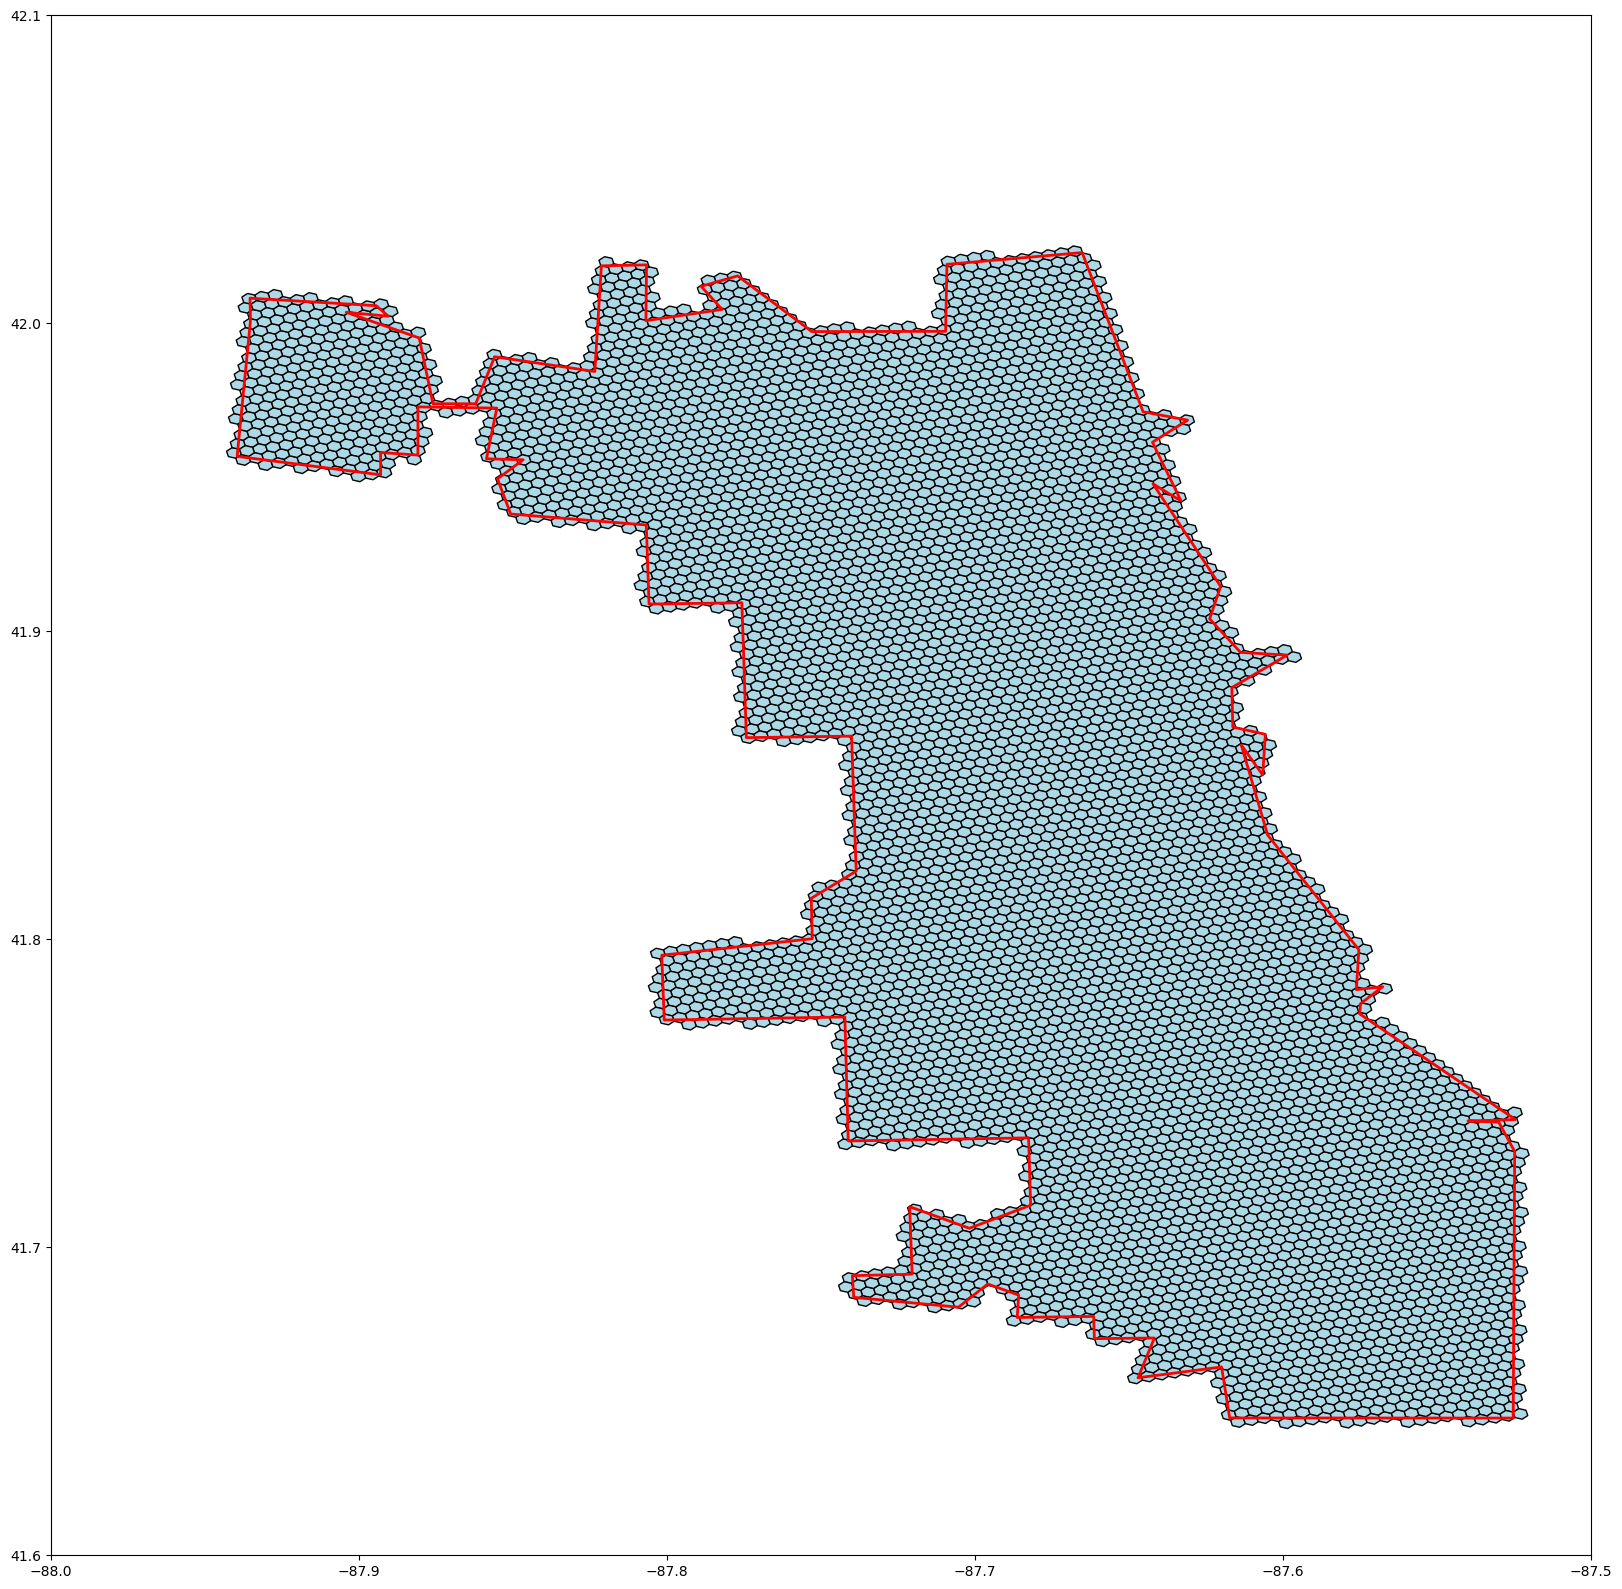

In [78]:
outer_boundary = [
    [41.6, -88],
    [41.6, -87.5],
    [42.1, -87.5],
    [42.1, -88]
]

# Step 2: Define resolution level
resolution = 9

# Step 3: Generate H3 hexagons covering the city
hexagons = h3.polyfill_polygon(outer_boundary, resolution)

# Convert hexagons to geopandas GeoDataFrame
hexagon_geometries = [
    Polygon(h3.h3_to_geo_boundary(hexagon, geo_json=True))
    for hexagon in hexagons
]

hexagon_gdf = gpd.GeoDataFrame(geometry=hexagon_geometries)

#Transform Y to X Coordinates and the other way arround to match structure from the chicago boundary
hexagon_gdf = hexagon_gdf.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

chicago_polygon = Polygon(city_boundary)
chicago_polygon = chicago_polygon.simplify(0.005)

#Transform Y to X Coordinates and the other way arround to match structure from the chicago boundary
hexagon_gdf = hexagon_gdf.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))


hexagons_within_boundary = [
    hexagon for hexagon in hexagon_gdf
    if (hexagon.intersects(chicago_polygon) or hexagon.within(chicago_polygon)) and not hexagon.within(chicago_polygon_hole)
]

hexagon_gdf = gpd.GeoDataFrame(geometry=hexagons_within_boundary)

# Create a plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the hexagons
hexagon_gdf.plot(ax=ax, facecolor='lightblue', edgecolor = 'black')


# Plot the city boundary
chicago_gdf = gpd.GeoDataFrame(geometry=[chicago_polygon])
chicago_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Set the axis limits
ax.set_xlim(-88, -87.5)
ax.set_ylim(41.6, 42.1)

# Display the plot
plt.show()

In [75]:
m = folium.Map([41.88065, -87.62642], zoom_start=10)
hexagon_gdf.explore(m = m)

## Overview over Illinoi as a state (testing of different additional datapoints)

In [ ]:
shape = gpd.read_file('data/poi/cb_2022_17_tract_500k.shp')
shape.plot()

In [ ]:
# Load the census tract shapefile for Chicago
shapefile_path = 'data/poi/cb_2022_17_tract_500k.shp'
chicago_map = gpd.read_file(shapefile_path)


In [ ]:
print(chicago_map.info)